In [214]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import ast
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

# Paths

In [215]:
data_dir = '/arc/projects/unions/ssl/data/raw/tiles/dwarforge'
table_dir = '/arc/home/heestersnick/dwarforge/tables'
dwarf_cat_file_old = 'all_known_dwarfs_processed.csv'
dwarf_cat_file_new = 'all_known_dwarfs_v2_processed.csv'
dwarf_cat_new = pd.read_csv(os.path.join(table_dir, dwarf_cat_file_new))
dwarf_cat_old = pd.read_csv(os.path.join(table_dir, dwarf_cat_file_old))

# Functions

In [216]:
band_dict = {
    'cfis-u': {
        'name': 'CFIS',
        'band': 'u',
        'vos': 'vos:cfis/tiles_DR5/',
        'suffix': '.u',
        'delimiter': '.',
        'fits_ext': 0,
        'zfill': 3,
        'zp': 30.0,
    },
    'whigs-g': {
        'name': 'calexp-CFIS',
        'band': 'g',
        'vos': 'vos:cfis/whigs/stack_images_CFIS_scheme/',
        'suffix': '',
        'delimiter': '_',
        'fits_ext': 1,
        'zfill': 0,
        'zp': 27.0,
    },
    'cfis_lsb-r': {
        'name': 'CFIS_LSB',
        'band': 'r',
        'vos': 'vos:cfis/tiles_LSB_DR5/',
        'suffix': '.r',
        'delimiter': '.',
        'fits_ext': 0,
        'zfill': 3,
        'zp': 30.0,
    },
    'ps-i': {
        'name': 'PSS.DR4',
        'band': 'i',
        'vos': 'vos:cfis/panstarrs/DR4/resamp/',
        'suffix': '.i',
        'delimiter': '.',
        'fits_ext': 0,
        'zfill': 3,
        'zp': 30.0,
    },
    'wishes-z': {
        'name': 'WISHES',
        'band': 'z',
        'vos': 'vos:cfis/wishes_1/coadd/',
        'suffix': '.z',
        'delimiter': '.',
        'fits_ext': 1,
        'zfill': 0,
        'zp': 27.0,
    },
    'ps-z': {
        'name': 'PSS.DR4',
        'band': 'ps-z',
        'vos': 'vos:cfis/panstarrs/DR4/resamp/',
        'suffix': '.z',
        'delimiter': '.',
        'fits_ext': 0,
        'zfill': 3,
        'zp': 30.0,
    },
}

def zfill_tile(tile):
    return f'{str(tile[0]).zfill(3)}_{str(tile[1]).zfill(3)}'

def labels_to_df(parent_folder, tile_list, dwarf_df):
    k = 0
    unmatched_dwarf_counter = 0
    unmatched_tile_counter = 0
    additional_dwarf_counter = 0
    for tile in tqdm(tile_list):
        # Convert tile tuple to folder name format
        folder_name = zfill_tile(tile)
        
        # Construct the full path to the parquet file
        tile_nums_zfill = folder_name.split('_')
        file_path = os.path.join(parent_folder, folder_name, "cfis_lsb-r", f"CFIS_LSB.{tile_nums_zfill[0]}.{tile_nums_zfill[1]}.r_rebin_det_params.parquet")
        fits_name = f'CFIS_LSB.{tile_nums_zfill[0]}.{tile_nums_zfill[1]}.r_rebin_seg.fits'
        fits_path = os.path.join(parent_folder, folder_name, "cfis_lsb-r", fits_name)
        
        if os.path.exists(file_path):
            try:
                # Attempt to read the parquet file
                det_df = pd.read_parquet(file_path)
                det_df_updated = det_df.copy()
                dwarfs_in_tile = dwarf_df[dwarf_df['tile'] == str(tile)].reset_index(drop=True)
                _, header = open_fits(fits_path, fits_ext=0)
                additional_dwarfs = check_objects_in_neighboring_tiles(str(tile), dwarf_df, header)

                if not additional_dwarfs.empty:
                    dwarfs_in_tile = pd.concat([dwarfs_in_tile, additional_dwarfs]).reset_index(drop=True)

                det_idx_lsb, lsb_matches, lsb_unmatches, _ = match_cats(det_df_updated, dwarfs_in_tile, tile, header, max_sep=15.0)

                # add lsb labels to detections dataframe
                det_df_updated['lsb'] = np.nan
                det_df_updated['ID_known'] = np.nan

                if len(det_idx_lsb) > 0:
                    print(f'Found {len(det_idx_lsb)} lsb detections for tile {tile}.')
                    det_df_updated.loc[det_idx_lsb, 'lsb'] = 1
                    # Initialize the column to accept strings
                    det_df_updated['ID_known'] = det_df_updated['ID_known'].astype(object)
                    det_df_updated.loc[det_idx_lsb, 'ID_known'] = lsb_matches['ID'].values
                    # print(
                    #     f'Added {np.count_nonzero(~np.isnan(det_df_updated["lsb"]))} LSB labels to the detection dataframe for tile {tile}.'
                    # )
                    k += 1
                    additional_dwarf_counter += len(additional_dwarfs)

                if len(lsb_unmatches) > 0:
                    print(f'Found {len(lsb_unmatches)} unmatched dwarf for tile: {tile}.')
                    unmatched_tile_counter += 1
                    unmatched_dwarf_counter += len(lsb_unmatches)

                # Save updated dataframe
                det_df_updated.to_parquet(file_path, index=False)
            except Exception as e:
                print(f'Something went wrong for tile {tile}: {e}')
    print(f'Was able to match {k}/{len(tile_list)} tiles.')
    print(f'There were {unmatched_dwarf_counter} unmatched dwarfs in {unmatched_tile_counter} tiles.')
    print(f'{additional_dwarf_counter} dwarfs are in multiple tiles.')

def open_fits(file_path, fits_ext):
    """
    Open fits file and return data and header.

    Args:
        file_path (str): name of the fits file
        fits_ext (int): extension of the fits file

    Returns:
        data (numpy.ndarray): image data
        header (fits header): header of the fits file
    """
    # logger.debug(f'Opening fits file {os.path.basename(file_path)}..')
    with fits.open(file_path, memmap=True) as hdul:
        data = hdul[fits_ext].data.astype(np.float32)  # type: ignore
        header = hdul[fits_ext].header  # type: ignore
    # logger.debug(f'Fits file {os.path.basename(file_path)} opened.')
    return data, header
                
def check_objects_in_neighboring_tiles(tile, dwarfs_df, header):
    wcs = WCS(header)
    # Get neighboring tile numbers
    neighboring_tiles = get_neighboring_tile_numbers(tile)

    # Filter dwarfs in neighboring tiles
    neighboring_dwarfs = dwarfs_df[dwarfs_df['tile'].isin(neighboring_tiles)]

    # Check which of these dwarfs are actually within the current tile's boundaries
    dwarfs_in_current_tile = neighboring_dwarfs[
        neighboring_dwarfs.apply(
            lambda row: wcs.footprint_contains(
                SkyCoord(row['ra'], row['dec'], unit='deg', frame='icrs')
            ),
            axis=1,
        )
    ]

    return dwarfs_in_current_tile

def get_neighboring_tile_numbers(tile):
    tile = ast.literal_eval(tile)
    x, y = map(int, tile)
    neighbors = [
        (x - 1, y - 1),
        (x - 1, y),
        (x - 1, y + 1),
        (x, y - 1),
        (x, y + 1),
        (x + 1, y - 1),
        (x + 1, y),
        (x + 1, y + 1),
    ]
    return [f'({nx:03d}, {ny:03d})' for nx, ny in neighbors if 0 <= nx < 1000 and 0 <= ny < 1000]

def dwarfs_to_df(parent_folder):
    # Pattern to match all relevant parquet files
    pattern = os.path.join(parent_folder, "*_*", "cfis_lsb-r", "CFIS_LSB.*.r_rebin_det_params.parquet")
    
    # List to store filtered dataframes
    filtered_dfs = []
    
    # Iterate through all matching files
    for file in tqdm(glob(pattern)):
        try:
            # Attempt to read the parquet file
            df = pd.read_parquet(file)
            # Check if 'label' column exists
            if 'lsb' in df.columns:
                # Filter rows where label is 1
                df_filtered = df[df['lsb'] == 1]
                
                if not df_filtered.empty:
                    filtered_dfs.append(df_filtered)
            # If 'label' column doesn't exist, we skip this file
        
        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")
            continue
        
        # The file is automatically closed after reading
    
    # Combine all dataframes
    if filtered_dfs:
        final_df = pd.concat(filtered_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return an empty dataframe if no data found

def gather_training_data(parent_folder, in_dict, band='cfis_lsb-r', n_neighbors=1):
    zfill = in_dict[band]['zfill']
    file_prefix = in_dict[band]['name']
    delimiter = in_dict[band]['delimiter']
    suffix = in_dict[band]['suffix']
    pattern = os.path.join(parent_folder, "*_*", band, f"{file_prefix}{delimiter}*{suffix}_rebin_star_mask*_det_params.parquet")
    
    all_examples = []
    
    for file in tqdm(glob(pattern)):
        try:
            filename = os.path.basename(file)
            tile_numbers = filename.split(f'{delimiter}')[1:3]
            tile_id = f"{tile_numbers[0]}.{tile_numbers[1]}"
            
            df = pd.read_parquet(file)
            
            if 'lsb' in df.columns:
                positive_examples = df[df['lsb'] == 1].copy()
                potential_negatives = df[df['lsb'].isna()].copy()
                
                if not positive_examples.empty and not potential_negatives.empty:
                    nn = NearestNeighbors(n_neighbors=len(potential_negatives), metric='euclidean')
                    nn.fit(potential_negatives[['ra', 'dec']])
                    
                    used_negatives = set()  # Set to keep track of used negative examples in this field
                    all_file_examples = []
                    
                    for idx, lsb_obj in positive_examples.iterrows():
                        lsb_df = pd.DataFrame({'ra': [lsb_obj['ra']], 'dec': [lsb_obj['dec']]})
                        
                        distances, indices = nn.kneighbors(lsb_df)
                        
                        # Find n_neighbors unique negative examples within this field
                        unique_negatives = []
                        for index in indices[0]:
                            if index not in used_negatives:
                                unique_negatives.append(index)
                                used_negatives.add(index)
                                if len(unique_negatives) == n_neighbors:
                                    break
                        
                        # If we couldn't find enough unique negatives, continue to the next positive example
                        if len(unique_negatives) < n_neighbors:
                            continue
                        
                        nearest_neighbors = potential_negatives.iloc[unique_negatives].copy()
                        
                        lsb_obj['example_id'] = f"{tile_id}.{lsb_obj['ID']}"
                        
                        nearest_neighbors['example_id'] = nearest_neighbors['ID'].apply(lambda x: f"{tile_id}.{x}")
                        nearest_neighbors['lsb'] = 0  # Set to 0 for negative examples
                        nearest_neighbors['associated_lsb_ra'] = lsb_obj['ra']
                        nearest_neighbors['associated_lsb_dec'] = lsb_obj['dec']
                        
                        all_file_examples.append(pd.concat([lsb_obj.to_frame().T, nearest_neighbors]))
                    
                    if all_file_examples:
                        all_examples.append(pd.concat(all_file_examples))
            
        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")
            continue
    
    if all_examples:
        final_df = pd.concat(all_examples, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()

def create_cartesian_kdtree(ra, dec):
    """
    Create a KD-Tree using Cartesian coordinates converted from RA and Dec.
    
    :param ra: Right Ascension in degrees
    :param dec: Declination in degrees
    :return: cKDTree object and the corresponding SkyCoord object
    """
    coords = SkyCoord(ra, dec, unit='deg', frame='icrs')
    xyz = coords.cartesian.xyz.value.T
    tree = cKDTree(xyz)
    return tree, coords

def match_cats(df_det, df_label, tile, pixel_scale, max_sep=15.0, re_multiplier=4.0):
    tree, _ = create_cartesian_kdtree(df_det['ra'].values, df_det['dec'].values)
    matches = []
    potential_matches_df = pd.DataFrame()
    for idx, known in df_label.iterrows():
        known_coords = SkyCoord(known['ra'], known['dec'], unit='deg')
        known_coords_xyz = known_coords.cartesian.xyz.value
        
        # Calculate base search radius in degrees
        base_search_radius = max_sep / 3600  # Convert arcseconds to degrees
        
        # Adaptive search radius (if 're' is available)
        if 're' in known and known['re'] is not None and not np.isnan(known['re']) and known['re'] > 0:
            adaptive_radius = known['re'] * re_multiplier / 3600  # Convert to degrees
            search_radius = max(base_search_radius, adaptive_radius)
        else:
            search_radius = base_search_radius
            
        search_radius_chord = 2 * np.sin(np.deg2rad(search_radius) / 2)
        
        potential_match_indices = tree.query_ball_point(known_coords_xyz, search_radius_chord)
        potential_matches = df_det.iloc[potential_match_indices]
        
        print(f'potential matches for {known["ID"]}: {len(potential_matches)}')
        
        potential_matches_df = pd.concat([potential_matches_df, potential_matches])
        if len(potential_matches) > 0:
            potential_matches_coords = SkyCoord(potential_matches['ra'], potential_matches['dec'], unit='deg')
            distances = known_coords.separation(potential_matches_coords).arcsec
            max_n_pix = potential_matches['n_pix'].max()
            max_mu = potential_matches['mu'].max()
            scores = []
            for i, det in potential_matches.iterrows():
                size_score = np.log1p(det['n_pix']) / np.log1p(max_n_pix)
                lsb_score = det['mu'] / max_mu
                distance = distances[potential_matches.index.get_loc(i)]
                distance_score = 1 - (distance / (3600 * search_radius))  # Normalized distance score
                score = (
                    lsb_score * 0.2
                    + size_score * 0.4
                    + distance_score * 0.4
                )
                print(f'object: {det["ID"]}; lsb score: {lsb_score:.4f}, size score: {size_score:.4f}, distance score: {distance_score:.4f}')
                print(f'object: {det["ID"]}; total score: {score:.4f}; distance: {distance:.2f} arcsec')
                scores.append((i, score, distance))
            best_match = max(scores, key=lambda x: x[1])
            matches.append((idx, best_match[0], best_match[2]))
    
    if matches:
        label_match_idx, det_match_idx, match_distances = zip(*matches)
    else:
        label_match_idx, det_match_idx, match_distances = [], [], []
    label_matches = df_label.loc[list(label_match_idx)].reset_index(drop=True)
    label_unmatches = df_label.drop(list(label_match_idx)).reset_index(drop=True)
    det_matches = df_det.loc[list(det_match_idx)].reset_index(drop=True)
    det_matches['match_distance'] = match_distances
    return list(det_match_idx), label_matches, label_unmatches, det_matches

def get_tile_list(dwarf_cat):
    tiles = dwarf_cat['tile'].values
    non_nan_tiles = [x for x in tiles if x is not np.nan]
    str_to_tuple = [ast.literal_eval(item) for item in non_nan_tiles]
    unique_tiles = list(set(str_to_tuple))
    return unique_tiles

def check_bands(bands_str, to_check):
    if isinstance(bands_str, str):
        if bands_str.startswith('['):
            # Handle string representation of a list
            try:
                bands_list = ast.literal_eval(bands_str)
                return all(band in bands_list for band in to_check)
            except:
                return False
        else:
            # Handle simple string format
            return all(band in bands_str for band in to_check)
    return False  # Return False for NaN values

def check_availability(dwarf_cat, check_for_bands):
    df_select = dwarf_cat.loc[(~dwarf_cat['tile'].isna()) & (dwarf_cat['bands'].apply(lambda x: check_bands(x, check_for_bands)))].reset_index(drop=True)
    return df_select

def check_param_filter(data, a, b, band):
    params_field = data.copy()
    df_dwarf = data.loc[data['lsb']==1].reset_index(drop=True)

    if band == 'cfis_lsb-r':
        conditions = {
                'mu': (22.0, None),  # (min, max), None means no limit
                're_arcsec': (1.6, 55.),
                'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.39, 19.),
                'r_90_arcsec': (2.3, 150.),
                'r_fwhm_arcsec': (0.4, 10.6),
                'mu_median': (0.3, 29.),
                'mu_mean': (0.4, 70.),
                'mu_max': (1.1, 5700.),
                'total_flux': (55, None),
                'mag': (13.8, 25.7),
                
            }

        # mag vs mu filter
        # params_field = params_field[params_field['mu'] > (0.5952 * params_field['mag'] + 12.5157)]
        params_field = params_field[params_field['mu'] > (a * params_field['mag'] + b)]
        # mag vs mu_max filter
        params_field = params_field[params_field['mu_max'] < (1.2e10 * np.exp(0.84 * params_field['mag']))]
        # r_90 vs r_10
        params_field = params_field[params_field['r_90_arcsec'] < (12.0000*params_field['r_10_arcsec'] + 20.0000)]
        # r_90 vs re
        params_field = params_field[params_field['r_90_arcsec'] < (3.0*params_field['re_arcsec'] + 9.0000)]
        # mu_median vs re
        params_field = params_field[params_field['mu_median'] < (4.0*params_field['re_arcsec'] + 4.0000)]
        # mu_median vs r_10
        params_field = params_field[params_field['mu_median'] < (4.0*params_field['r_10_arcsec'] + 12.0000)]
        # mu_median vs r_90
        params_field = params_field[params_field['mu_median'] < (0.3*params_field['r_90_arcsec'] + 15.0000)]
        # mu_max vs r_90
        params_field = params_field[params_field['mu_max'] < (120.0*params_field['r_90_arcsec'] + 650.0000)]

    elif band == 'whigs-g':
        conditions = {
                'mu': (20.0, None),  # (min, max), None means no limit
                're_arcsec': (1.6, 55.),
                'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.39, 8.),
                'r_90_arcsec': (2.5, 40.),
                'r_fwhm_arcsec': (0.4, 7.5),
                'mu_median': (0.1, 12.),
                'mu_mean': (0.25, 17.3),
                'mu_max': (1.7, 2600.),
                'total_flux': (39, None),
                'mag': (15.3, 23.0),
                
            }

        #mag vs mu filter
        params_field = params_field[params_field['mu'] > (0.6300 * params_field['mag'] + 10.4000)]
        # params_field = params_field[params_field['mu'] > (a * params_field['mag'] + b)]
        #mag vs mu_max filter
        params_field = params_field[params_field['mu_max'] < (-20.0 * params_field['mag'] + 500.0)]
        #r_90 vs r_10
        params_field = params_field[params_field['r_90_arcsec'] > (4.3025*params_field['r_10_arcsec'] -1.5000)]
        # r_90 vs re
        params_field = params_field[params_field['r_90_arcsec'] < (1.9000*params_field['re_arcsec'] + 3.5000)]
        # mu_median vs re
        params_field = params_field[params_field['mu_median'] < (0.1500*params_field['re_arcsec'] + 3.3)]
        # mu_median vs r_10
        params_field = params_field[params_field['mu_median'] < (3.0*params_field['r_10_arcsec'] + 1.0000)]
        # mu_median vs r_90
        params_field = params_field[params_field['mu_median'] < (0.0800*params_field['r_90_arcsec'] + 3.5)]
        # mu_max vs r_90
        params_field = params_field[params_field['mu_max'] < (14.0*params_field['r_90_arcsec'] + 20)]

    elif band == 'ps-i':
        conditions = {
                'mu': (22.0, None),  # (min, max), None means no limit
                're_arcsec': (1.6, 46.),
                'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.39, 16.2),
                'r_90_arcsec': (2.51, 85.),
                'r_fwhm_arcsec': (0.4, 14.2),
                'mu_median': (0.35, 34.),
                'mu_mean': (0.4, 103.),
                'mu_max': (2, 8300.),
                'total_flux': (68, None),
                'mag': (15.8, 25.3),
                
            }

        # mag vs mu filter
        params_field = params_field[params_field['mu'] > (a * params_field['mag'] + b)]
        # mag vs mu_max filter
        params_field = params_field[params_field['mu_max'] < 5593.3712 / (1 + np.exp(0.9174 * (params_field['mag'] - 16.1930))) * np.exp(-0.0000 * params_field['mag']) + 200.0000]
        # r_90 vs r_10
        params_field = params_field[params_field['r_90_arcsec'] < (12.0000*params_field['r_10_arcsec'] + 3.0000)]
        # r_90 vs re
        params_field = params_field[params_field['r_90_arcsec'] < (3.0*params_field['re_arcsec'] + 3.8)]
        # mu_median vs re
        params_field = params_field[params_field['mu_median'] < (2.0*params_field['re_arcsec'] + 8.0000)]
        # mu_median vs r_10
        params_field = params_field[params_field['mu_median'] < (4.0*params_field['r_10_arcsec'] + 12.0000)]
        # mu_median vs r_90
        params_field = params_field[params_field['mu_median'] < (4.0*params_field['r_90_arcsec'] + 9.5000)]
        # mu_max vs r_90
        params_field = params_field[params_field['mu_max'] < (35.0*params_field['r_90_arcsec'] + 100.0000)]
        # r_25 vs r_10
        params_field = params_field[params_field['r_25_arcsec'] < (2.5*params_field['r_10_arcsec'] + 1.0000)]
    else:
        print(f'Conditions not implemented for band {band}.')
        return
    
    for column, (min_val, max_val) in conditions.items():
        if min_val is not None:
            params_field = params_field[params_field[column] > min_val]
        if max_val is not None:
            params_field = params_field[params_field[column] < max_val]
            
    # Remove streaks
    params_field = params_field[(params_field['axis_ratio'] >= 0.17) | (params_field['n_pix'] <= 1000)]
    
    # Remove previous index and reset
    params_field = params_field.reset_index(drop=True)
    
    print(f'Filtered out {len(data.loc[data["lsb"]==1])-len(params_field.loc[params_field["lsb"]==1])} real dwarfs from a total of {len(df_dwarf)}.')
    print(f'Filtered out {len(data.loc[data["lsb"]==0])-len(params_field.loc[params_field["lsb"]==0])} other objects from a total of {len(data.loc[data["lsb"]==0])}')

    return params_field

def check_param_filter_new(data: pd.DataFrame, a: float, b: float, band: str) -> pd.DataFrame:
    params_field = data.copy()
    df_dwarf = data.loc[data['lsb'] == 1].reset_index(drop=True)

    # Define band-specific conditions
    band_conditions = {
        'cfis_lsb-r': {
            'basic': {
                'mu': (22.0, None), 're_arcsec': (1.6, 55.), 'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.39, 19.), 'r_90_arcsec': (2.3, 150.), 'r_fwhm_arcsec': (0.4, 10.6),
                'mu_median': (0.3, 29.), 'mu_mean': (0.4, 70.), 'mu_max': (1.1, 5700.),
                'total_flux': (55, None), 'mag': (13.8, 25.7)
            },
            'complex': [
                lambda df: df['mu'] > (a * df['mag'] + b),
                lambda df: df['mu_max'] < (1.2e10 * np.exp(0.84 * df['mag'])),
                lambda df: df['r_90_arcsec'] < (12.0000 * df['r_10_arcsec'] + 20.0000),
                lambda df: df['r_90_arcsec'] < (3.0 * df['re_arcsec'] + 9.0000),
                lambda df: df['mu_median'] < (4.0 * df['re_arcsec'] + 4.0000),
                lambda df: df['mu_median'] < (4.0 * df['r_10_arcsec'] + 12.0000),
                lambda df: df['mu_median'] < (0.3 * df['r_90_arcsec'] + 15.0000),
                lambda df: df['mu_max'] < (120.0 * df['r_90_arcsec'] + 650.0000)
            ]
        },
        'whigs-g': {
            'basic': {
                'mu': (21.0, None), 're_arcsec': (1.6, 55.), 'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.39, 8.), 'r_90_arcsec': (2.5, 40.), 'r_fwhm_arcsec': (0.4, 7.5),
                'mu_median': (0.1, 12.), 'mu_mean': (0.25, 17.3), 'mu_max': (1.7, 2600.),
                'total_flux': (39, None), 'mag': (15.3, 23.0)
            },
            'complex': [
                lambda df: df['mu'] > (0.6300 * df['mag'] + 10.4000),
                lambda df: df['mu_max'] > (500.0 * -20.0 * df['mag']),
                lambda df: df['r_90_arcsec'] > (4.3025 * df['r_10_arcsec'] - 1.5000),
                lambda df: df['r_90_arcsec'] < (1.9000 * df['re_arcsec'] + 3.5000),
                lambda df: df['mu_median'] < (0.1500 * df['re_arcsec'] + 3.3),
                lambda df: df['mu_median'] < (3.0 * df['r_10_arcsec'] + 1.0000),
                lambda df: df['mu_median'] < (0.0800 * df['r_90_arcsec'] + 3.5),
                lambda df: df['mu_max'] < (14.0 * df['r_90_arcsec'] + 20)
            ]
        },
        'ps-i': {
            'basic': {
                'mu': (22.0, None), 're_arcsec': (1.6, 55.), 'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.39, 19.), 'r_90_arcsec': (2.3, 150.), 'r_fwhm_arcsec': (0.4, 10.6),
                'mu_median': (0.3, 29.), 'mu_mean': (0.4, 70.), 'mu_max': (1.7, 5700.),
                'total_flux': (55, None), 'mag': (13.8, 25.7)
            },
            'complex': [
                lambda df: df['mu'] > (a * df['mag'] + b),
                lambda df: df['mu_max'] < (1.2e10 * np.exp(0.84 * df['mag'])),
                lambda df: df['r_90_arcsec'] < (12.0000 * df['r_10_arcsec'] + 20.0000),
                lambda df: df['r_90_arcsec'] < (3.0 * df['re_arcsec'] + 9.0000),
                lambda df: df['mu_median'] < (4.0 * df['re_arcsec'] + 4.0000),
                lambda df: df['mu_median'] < (4.0 * df['r_10_arcsec'] + 12.0000),
                lambda df: df['mu_median'] < (0.3 * df['r_90_arcsec'] + 15.0000),
                lambda df: df['mu_max'] < (120.0 * df['r_90_arcsec'] + 650.0000)
            ]
        }
    }

    if band not in band_conditions:
        print(f'Conditions not implemented for band {band}.')
        return None

    conditions = band_conditions[band]

    # Apply basic conditions
    for column, (min_val, max_val) in conditions['basic'].items():
        if min_val is not None:
            params_field = params_field[params_field[column] > min_val]
        if max_val is not None:
            params_field = params_field[params_field[column] < max_val]

    # Apply complex conditions
    for condition in conditions['complex']:
        params_field = params_field[condition]

    # Remove streaks
    params_field = params_field[(params_field['axis_ratio'] >= 0.17) | (params_field['n_pix'] <= 1000)]

    # Reset index
    params_field = params_field.reset_index(drop=True)

    print(f'Filtered out {len(data.loc[data["lsb"]==1])-len(params_field.loc[params_field["lsb"]==1])} real dwarfs from a total of {len(df_dwarf)}.')
    print(f'Filtered out {len(data.loc[data["lsb"]==0])-len(params_field.loc[params_field["lsb"]==0])} other objects from a total of {len(data.loc[data["lsb"]==0])}')

    return params_field

def read_h5(cutout_dir):
    """
    Reads cutout data from HDF5 file
    :param cutout_dir: cutout directory
    :return: cutout data
    """
    with h5py.File(cutout_dir, 'r') as f:
        # Create empty dictionaries to store data for each group
        cutout_data = {}

        # Loop through datasets
        for dataset_name in f:
            data = np.array(f[dataset_name])
            cutout_data[dataset_name] = data
    return cutout_data

def cutout2d_segmented(data, tile_str, segmentation_mask, object_id, x, y, size, cutout_in):
    """
    Create 2d cutout from an image, applying a segmentation mask for a specific object.
    
    Args:
        data (numpy.ndarray): image data
        tile_str (str): tile numbers
        segmentation_mask (numpy.ndarray): segmentation mask with object IDs
        object_id (int): ID of the object to isolate in the cutout
        x (int): x-coordinate of cutout center
        y (int): y-coordinate of cutout center
        size (int): square cutout size
        cutout_in (numpy.ndarray): empty input cutout
    
    Raises:
        ValueError: if specified cutout has no overlap with the image data
    
    Returns:
        numpy.ndarray: 2d cutout (size x size pixels) with only the specified object
    """
    y_large, x_large = data.shape
    size_half = size // 2
    y_start = max(0, y - size_half)
    y_end = min(y_large, y + (size - size_half))
    x_start = max(0, x - size_half)
    x_end = min(x_large, x + (size - size_half))
    
    if y_start >= y_end or x_start >= x_end:
        logger.error(f'Tile: {tile_str}: an object is fully outside of the image.')
    
    cutout_slice = slice(y_start - y + size_half, y_end - y + size_half), slice(x_start - x + size_half, x_end - x + size_half)
    data_slice = slice(y_start, y_end), slice(x_start, x_end)
    
    # Apply data and segmentation mask
    cutout_in[cutout_slice] = data[data_slice] * (segmentation_mask[data_slice] == object_id)
    
    return cutout_in

def create_segmented_cutouts(data, tile_str, segmentation_mask, object_ids, xs, ys, cutout_size):
    """
    Create cutouts for multiple objects efficiently.
    
    Args:
        data (numpy.ndarray): image data
        segmentation_mask (numpy.ndarray): segmentation mask with object IDs
        object_ids (numpy.ndarray): array of object IDs
        xs (numpy.ndarray): array of x-coordinates
        ys (numpy.ndarray): array of y-coordinates
        cutout_size (int): size of each cutout
    
    Returns:
        numpy.ndarray: array of cutouts
    """
    cutouts = np.zeros((len(object_ids), cutout_size, cutout_size), dtype=data.dtype)
    cutout_empty = np.zeros((cutout_size, cutout_size), dtype=data.dtype)
    
    for i, (obj_id, x, y) in enumerate(zip(object_ids, xs, ys)):
        cutouts[i] = cutout2d_segmented(data, tile_str, segmentation_mask, obj_id, x, y, cutout_size, cutout_empty.copy())
    
    return cutouts

def make_cutouts(data, tile_str, df, cutout_size=64):
    xs = np.floor(mto_det.X.values + 0.5).astype(np.int32)
    ys = np.floor(mto_det.Y.values + 0.5).astype(np.int32)
    object_ids = mto_det['ID'].values  # Assuming the index is the object ID

    cutout_start = time.time()
    cutouts = create_segmented_cutouts(data, tile_str, mto_seg, object_ids, xs, ys, cutout_size)
    print(f'Done in {time.time()-cutout_start:.2f} seconds.')
    
    return cutouts

def plot_cutouts(cutouts, num_cutouts=9, figsize=(8, 8), percent=98.5):
    num_cutouts = min(num_cutouts, len(cutouts))
    rows = int(np.ceil(np.sqrt(num_cutouts)))
    cols = int(np.ceil(num_cutouts / rows))
    plt.figure()
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle("Segmented Object Cutouts", fontsize=16)
    
    for i in range(num_cutouts):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        norm = simple_norm(cutouts[i], 'sqrt', percent=percent)
        im = ax.imshow(cutouts[i], cmap='gray_r', origin='lower', norm=norm)
        ax.set_title(f"Object {i+1}")
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    for i in range(num_cutouts, rows * cols):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        ax.remove()
    
    plt.tight_layout()
    plt.show()

# Analysis

In [6]:
tile_list = get_tile_list(dwarf_cat)

### r

In [218]:
training_data_r = gather_training_data(data_dir, in_dict=band_dict, band='cfis_lsb-r', n_neighbors=10)
training_data_r.to_csv(os.path.join(table_dir, 'training_data_r_10x_rf.csv'), index=False)

  0%|          | 0/20677 [00:00<?, ?it/s]

In [227]:
training_data_file_r = 'training_data_10x_rf_v2.csv'
training_data_r = pd.read_csv(os.path.join(table_dir, training_data_file_r))

df_dwarf_r = training_data_r.loc[training_data_r['lsb'] == 1].reset_index(drop=True)
df_other_r = training_data_r.loc[training_data_r['lsb'] != 1].reset_index(drop=True)

### g

In [159]:
training_data_g = gather_training_data(data_dir, in_dict=band_dict, band='whigs-g', n_neighbors=10)
training_data_g.to_csv(os.path.join(table_dir, 'training_data_g_10x_rf.csv'), index=False)

  0%|          | 0/1640 [00:00<?, ?it/s]

In [162]:
training_data_file_g = 'training_data_g_10x_rf.csv'
training_data_g = pd.read_csv(os.path.join(table_dir, training_data_file_g))

df_dwarf_g = training_data_g.loc[training_data_g['lsb'] == 1].reset_index(drop=True)
df_other_g = training_data_g.loc[training_data_g['lsb'] != 1].reset_index(drop=True)

### i

In [16]:
# training_data = gather_training_data(data_dir, in_dict=band_dict, band='ps-i', n_neighbors=10)
# training_data.to_csv(os.path.join(table_dir, 'training_data_i_10x_rf.csv'), index=False)

  0%|          | 0/1736 [00:00<?, ?it/s]

In [133]:
training_data_file_i = 'training_data_i_10x_rf.csv'
training_data_i = pd.read_csv(os.path.join(table_dir, training_data_file_i))

df_dwarf_i = training_data_i.loc[training_data_i['lsb'] == 1].reset_index(drop=True)
df_other_i = training_data_i.loc[training_data_i['lsb'] != 1].reset_index(drop=True)

### Check band availability

In [23]:
# bands_to_check = ['r']
# df_avail_old = check_availability(dwarf_cat_old, bands_to_check)
# print(f'Using the old catalog, there are {len(df_avail_old)} known dwarfs in {bands_to_check} in the footprint.')

Using the old catalog, there are 1111 known dwarfs in ['r'] in the footprint.


In [222]:
bands_to_check = ['r','i','g']
df_avail = check_availability(dwarf_cat_new, bands_to_check)
print(f'Using the new catalog, there are {len(df_avail)} known dwarfs in {bands_to_check} in the footprint.')

Using the new catalog, there are 2058 known dwarfs in ['r', 'i', 'g'] in the footprint.


In [228]:
def func_lin(x, a, b):
    return a*x + b

def func_p2(x, a, b, c):
    return a*x**2 + b*x + c

def func_p3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def func_exp(x, a, b):
    return a * np.exp(-b * x)

def plot_params(df_dwarf, df_other, param1, param2, func_type='linear', func_params=None, annotate=False, plot_func=True):
    plt.figure(figsize=(8, 8))
    plt.scatter(df_other[param1].values, df_other[param2].values, marker='o', s=6, color='red', alpha=0.3, label='Other')
    plt.scatter(df_dwarf[param1].values, df_dwarf[param2].values, marker='o', s=10, color='green', alpha=0.3, label='Dwarf')
    
    filtered_dwarfs = 0
    x_range = np.linspace(df_other[param1].min(), df_other[param1].max(), 100)
    
    if func_type == 'linear':
        y_func = func_lin(x_range, *func_params)
        func_label = f'y = {func_params[0]:.2f}x + {func_params[1]:.2f}'
    elif func_type == 'quadratic':
        y_func = func_p2(x_range, *func_params)
        func_label = f'y = {func_params[0]:.2f}x² + {func_params[1]:.2f}x + {func_params[2]:.2f}'
    elif func_type == 'cubic':
        y_func = func_p3(x_range, *func_params)
        func_label = f'y = {func_params[0]:.2f}x³ + {func_params[1]:.2f}x² + {func_params[2]:.2f}x + {func_params[3]:.2f}'
    elif func_type == 'exp':
        y_func = func_exp(x_range, *func_params)
        func_label = f'y = {func_params[0]:.2f}e^({func_params[1]:.2f}*x)'
    else:
        raise ValueError("Unsupported function type. Choose 'linear', 'quadratic', or 'cubic'.")

    if plot_func:
        plt.plot(x_range, y_func, 'b-', label=func_label)
    
    for i, row in df_dwarf.iterrows():
        x_val = row[param1]
        y_val = row[param2]
        
        if func_type == 'linear':
            y_boundary = func_lin(x_val, *func_params)
        elif func_type == 'quadratic':
            y_boundary = func_p2(x_val, *func_params)
        elif func_type == 'cubic':
            y_boundary = func_p3(x_val, *func_params)
        elif func_type == 'exp':
            y_boundary = func_exp(x_val, *func_params)
        
        if y_val < y_boundary:
            text = f"{row['ID_known']} ra: {row['ra']:.4f}, dec: {row['dec']:.4f}"
            # print(text)
            filtered_dwarfs += 1
            if annotate:
                plt.annotate(text, (x_val, y_val), xytext=(5, 5), textcoords='offset points', fontsize=5, alpha=0.7)

    # plt.ylim(0,10**4)
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.title(f'Parameter Plot: {param1} vs {param2}')
    plt.legend()
    
    print(f'Filtered out {filtered_dwarfs} real dwarfs.')
    
    plt.show()

Filtered out 21 real dwarfs.


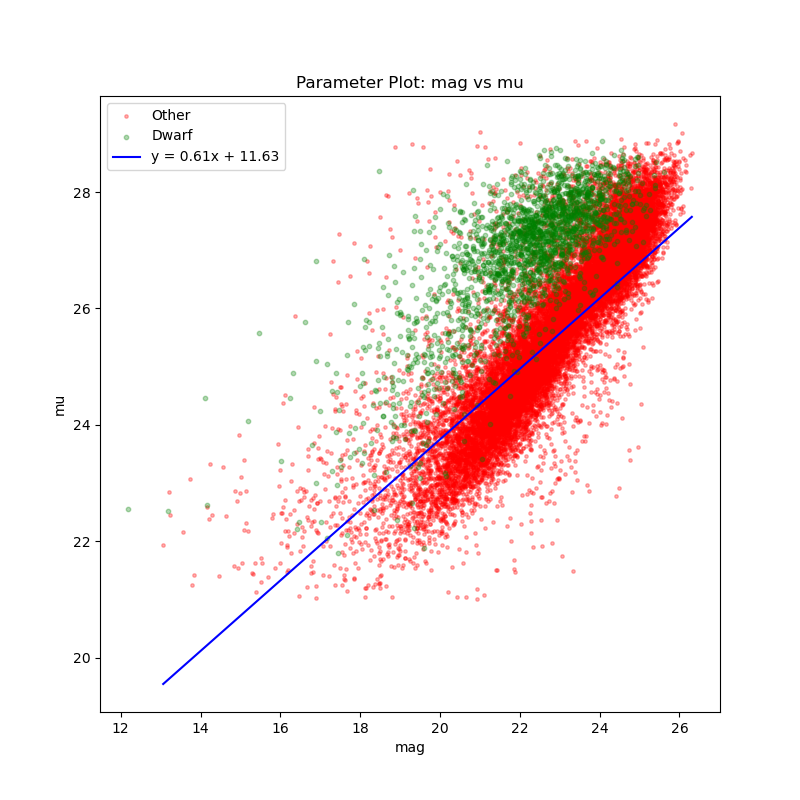

In [229]:
%matplotlib widget
param1, param2 = 'mag', 'mu' # 0.5952, 12.5157
plot_params(df_dwarf_r, df_other_r, param1, param2, func_type='linear', func_params=[0.6060, 11.6293], annotate=False, plot_func=True)

Filtered out 90 real dwarfs.


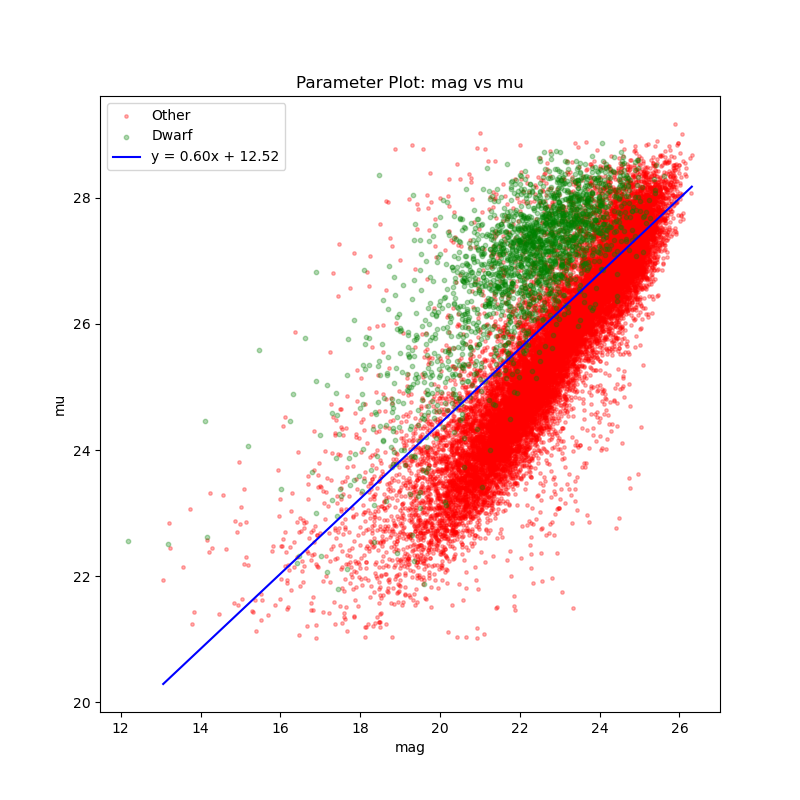

In [75]:
plot_params(df_dwarf2, df_other2, param1, param2, func_type='linear', func_params=[0.5952, 12.5157], annotate=False, plot_func=True)

In [71]:
len(df_dwarf1)

2092

Available function types: linear, polynomial, exponential, modified-exp, sigmoid-exp, steep-fall


Enter the function type you want to use:  linear
Enter conservativeness (0-1, default 0.95):  
Enter positive weight (default 10):  


Extracted linear parameters: coefficient = 1.8098, intercept = -0.2633

Linear separation line equation:
r_25_arcsec = max(1.8098*r_10_arcsec + -0.2633, 0)

Sensitivity (True Positive Rate): 0.0409
Specificity (True Negative Rate): 0.9893
Positive Predictive Value: 0.2760
xlim: -0.08945053869115066/19.200290397029864, ylim: 0.2457880952902703/33.14404657631352


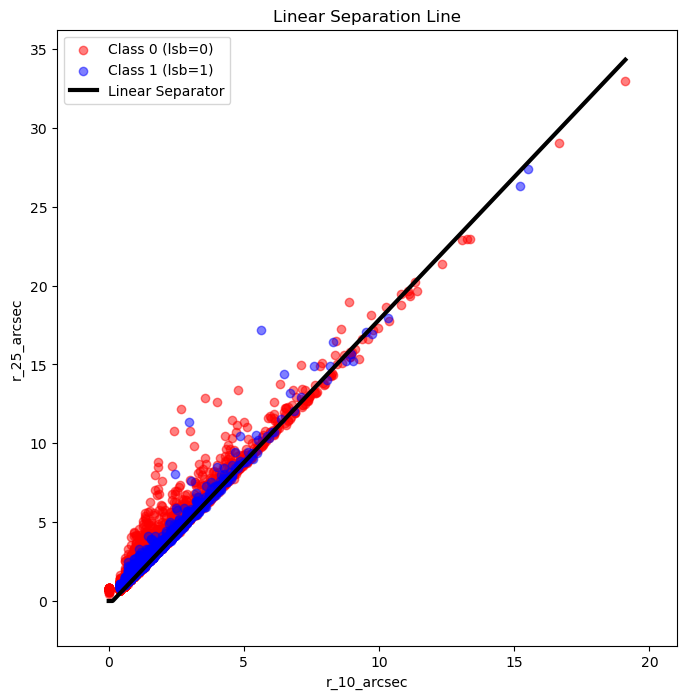


Are you satisfied with the fit? (yes/no):  yes



Final separator function:
r_25_arcsec = max(1.8098*r_10_arcsec + -0.2633, 0)


In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re
%matplotlib inline

def sigmoid_exp_func(x, a, b, c, d, e):
    return a / (1 + np.exp(b * (x - c))) * np.exp(-d * x) + e

def steep_fall(x, a, b):
    return a * np.exp(-b * x) / x

def find_separator(X, y, param1, param2, func_type='modified-exp', degree=3, positive_weight=10, conservativeness=0.95):
    sorted_indices = np.argsort(X[:, 0])
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]

    decision_points = []
    weights = []
    for i in range(1, len(y_sorted)):
        if y_sorted[i] != y_sorted[i-1]:
            mid_point = (X_sorted[i] + X_sorted[i-1]) / 2
            decision_points.append(mid_point)
            weights.append(positive_weight if y_sorted[i] == 1 else 1)
    decision_points = np.array(decision_points)
    weights = np.array(weights)

    if func_type == 'linear':
        coeffs = np.polyfit(decision_points[:, 0], decision_points[:, 1], 1, w=weights)
        sep_func = lambda x: np.maximum(coeffs[0] * x + coeffs[1], 0)
        equation = f"max({coeffs[0]:.4f}*{param1} + {coeffs[1]:.4f}, 0)"

    elif func_type == 'polynomial':
        def poly_exp_func(x, *coeffs):
            return np.exp(np.polyval(coeffs, x))
        
        p0 = np.polyfit(decision_points[:, 0], np.log(decision_points[:, 1]), degree)
        
        popt, _ = curve_fit(poly_exp_func, decision_points[:, 0], decision_points[:, 1], 
                            p0=p0, sigma=1/weights, maxfev=10000)
        
        sep_func = lambda x: poly_exp_func(x, *popt)
        equation = "exp(" + " + ".join([f"{popt[i]:.4f}*{param1}^{len(popt)-i-1}" for i in range(len(popt))]) + ")"

    elif func_type == 'exponential':
        def exp_func(x, a, b, c):
            return a * np.exp(-b * x) + c
        
        y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
        x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
        
        a_guess = y_max - y_min
        b_guess = 1 / (x_max - x_min)
        c_guess = y_min

        lower_bounds = [0, 0, 0]
        upper_bounds = [np.inf, np.inf, y_min]

        popt, _ = curve_fit(exp_func, decision_points[:, 0], decision_points[:, 1], 
                            p0=[a_guess, b_guess, c_guess], 
                            bounds=(lower_bounds, upper_bounds),
                            maxfev=10000)
        
        sep_func = lambda x: exp_func(x, *popt)
        equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) + {popt[2]:.4f}"

    elif func_type == 'modified-exp':
        def modified_exp_func(x, a, b, c, d):
            return a * np.exp(-b * (x ** c)) + d
        
        y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
        x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
        
        a_guess = y_max - y_min
        b_guess = 1 / (x_max - x_min)
        c_guess = 1
        d_guess = y_min

        lower_bounds = [0, 0, 0.1, 0]
        upper_bounds = [np.inf, np.inf, 2, y_min]

        try:
            popt, _ = curve_fit(modified_exp_func, decision_points[:, 0], decision_points[:, 1], 
                                p0=[a_guess, b_guess, c_guess, d_guess], 
                                bounds=(lower_bounds, upper_bounds),
                                maxfev=50000)  # Increased max iterations
            
            sep_func = lambda x: modified_exp_func(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * ({param1} ** {popt[2]:.4f})) + {popt[3]:.4f}"
        except RuntimeError:
            print("Modified exponential fit failed. Falling back to simple exponential.")
            return find_separator(X, y, param1, param2, 'exponential', degree, positive_weight, conservativeness)
    elif func_type == 'sigmoid-exp':
        y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
        x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
        
        a_guess = y_max - y_min
        b_guess = 1
        c_guess = (x_max + x_min) / 2
        d_guess = 0.1
        e_guess = y_min

        lower_bounds = [0, 0, x_min, 0, 0]
        upper_bounds = [np.inf, np.inf, x_max, np.inf, y_min]

        try:
            popt, _ = curve_fit(sigmoid_exp_func, decision_points[:, 0], decision_points[:, 1], 
                                p0=[a_guess, b_guess, c_guess, d_guess, e_guess], 
                                bounds=(lower_bounds, upper_bounds),
                                maxfev=50000)
            
            sep_func = lambda x: sigmoid_exp_func(x, *popt)
            equation = f"{popt[0]:.4f} / (1 + exp({popt[1]:.4f} * ({param1} - {popt[2]:.4f}))) * exp(-{popt[3]:.4f} * {param1}) + {popt[4]:.4f}"
        except RuntimeError:
            print("Sigmoid-exponential fit failed. Falling back to modified exponential.")
            return find_separator(X, y, param1, param2, 'modified-exp', degree, positive_weight, conservativeness)
    elif func_type == 'steep-fall':
        y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
        x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])

        a_guess = y_max - y_min
        b_guess = 1 / (x_max - x_min)

        lower_bounds = [0, 0]
        upper_bounds = [np.inf, np.inf]

        try:
            popt, _ = curve_fit(steep_fall, decision_points[:, 0], decision_points[:, 1], 
                                p0=[a_guess, b_guess], 
                                bounds=(lower_bounds, upper_bounds),
                                maxfev=50000)
            
            sep_func = lambda x: steep_fall(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) / {param1}"
        except RuntimeError:
            print("Steep fall fit failed. Falling back to exponential.")
            return find_separator(X, y, param1, param2, 'exponential', degree, positive_weight, conservativeness)
    else:
        raise ValueError("Invalid function type. Choose 'linear', 'polynomial', 'exponential', or 'modified-exp'.")

    # Apply conservativeness adjustment
    positive_examples = X[y == 1]
    distances = positive_examples[:, 1] - sep_func(positive_examples[:, 0])
    adjustment = np.percentile(distances[distances < 0], (1 - conservativeness) * 100)

    # Adjust the function
    if func_type == 'linear':
        coeffs[1] += adjustment
        sep_func = lambda x: np.maximum(coeffs[0] * x + coeffs[1], 0)
        equation = f"max({coeffs[0]:.4f}*{param1} + {coeffs[1]:.4f}, 0)"
    elif func_type == 'polynomial':
        popt[-1] += adjustment
        sep_func = lambda x: poly_exp_func(x, *popt)
        equation = "exp(" + " + ".join([f"{popt[i]:.4f}*{param1}^{len(popt)-i-1}" for i in range(len(popt))]) + ")"
    elif func_type in ['exponential', 'modified-exp', 'sigmoid-exp', 'steep-fall']:
        popt[0] *= (1 + adjustment / popt[0])
        if func_type == 'exponential':
            sep_func = lambda x: exp_func(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) + {popt[2]:.4f}"
        elif func_type == 'modified-exp':
            sep_func = lambda x: modified_exp_func(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * ({param1} ** {popt[2]:.4f})) + {popt[3]:.4f}"
        elif func_type == 'sigmoid-exp':
            sep_func = lambda x: sigmoid_exp_func(x, *popt)
            equation = f"{popt[0]:.4f} / (1 + exp({popt[1]:.4f} * ({param1} - {popt[2]:.4f}))) * exp(-{popt[3]:.4f} * {param1}) + {popt[4]:.4f}"
        else:  # steep-fall
            sep_func = lambda x: steep_fall(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) / {param1}"

    return sep_func, equation

def evaluate_separator(X, y, sep_func):
    y_pred = sep_func(X[:, 0]) > X[:, 1]
    true_positives = np.sum((y == 1) & (y_pred == 1))
    false_negatives = np.sum((y == 1) & (y_pred == 0))
    true_negatives = np.sum((y == 0) & (y_pred == 0))
    false_positives = np.sum((y == 0) & (y_pred == 1))
    
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    positive_predictive_value = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    
    return sensitivity, specificity, positive_predictive_value

def plot_separator(X, y, sep_func, param1, param2, func_type):
    plt.close('all')
    plt.figure(figsize=(8, 8))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', label='Class 0 (lsb=0)', alpha=0.5)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='b', label='Class 1 (lsb=1)', alpha=0.5)

    x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)
    plt.plot(x_range, sep_func(x_range), color='black', lw=3, label=f'{func_type.capitalize()} Separator')

    xinterval = X[:, 0].max() - X[:, 0].min()
    yinterval = X[:, 1].max() - X[:, 1].min()
    
    plt.xlim(X[:, 0].min()-(xinterval/10), X[:, 0].max()+(xinterval/10))
    plt.ylim(X[:, 1].min()-(yinterval/10), X[:, 1].max()+(yinterval/10))
    print(f'xlim: {X[:, 0].min()-(X[:, 0].mean()/10)}/{X[:, 0].max()+(X[:, 0].mean()/10)}, ylim: {X[:, 1].min()-(X[:, 1].mean()/10)}/{X[:, 1].max()+(X[:, 1].mean()/10)}')
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.legend()
    plt.title(f'{func_type.capitalize()} Separation Line')
    plt.show()

def adjust_parameters(func_type, popt, param1):
    print("\nCurrent parameters:")
    for i, param in enumerate(popt):
        print(f"Parameter {i}: {param:.6f}")
    
    while True:
        index = input("\nEnter the index of the parameter you want to adjust (or 'done' to finish): ")
        if index.lower() == 'done':
            break
        try:
            index = int(index)
            if 0 <= index < len(popt):
                new_value = float(input(f"Enter new value for parameter {index} (current: {popt[index]:.6f}): "))
                popt[index] = new_value
            else:
                print("Invalid index. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number or 'done'.")
    
    if func_type == 'linear':
        sep_func = lambda x: np.maximum(popt[0] * x + popt[1], 0)
        equation = f"max({popt[0]:.4f}*{param1} + {popt[1]:.4f}, 0)"
    elif func_type == 'polynomial':
        sep_func = lambda x: np.exp(np.polyval(popt, x))
        equation = "exp(" + " + ".join([f"{popt[i]:.4f}*{param1}^{len(popt)-i-1}" for i in range(len(popt))]) + ")"
    elif func_type == 'exponential':
        sep_func = lambda x: popt[0] * np.exp(-popt[1] * x) + popt[2]
        equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) + {popt[2]:.4f}"
    elif func_type == 'modified-exp':
        sep_func = lambda x: popt[0] * np.exp(-popt[1] * (x ** popt[2])) + popt[3]
        equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * ({param1} ** {popt[2]:.4f})) + {popt[3]:.4f}"
    elif func_type == 'sigmoid-exp':
        sep_func = lambda x: sigmoid_exp_func(x, *popt)
        equation = f"{popt[0]:.4f} / (1 + exp({popt[1]:.4f} * ({param1} - {popt[2]:.4f}))) * exp(-{popt[3]:.4f} * {param1}) + {popt[4]:.4f}"
    elif func_type == 'steep-fall':
        sep_func = lambda x: steep_fall(x, *popt)
        equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) / {param1}"
    
    return sep_func, equation, popt

def main(df, param1, param2, class_column):
    X = df[[param1, param2]].values
    y = df[class_column].values

    func_types = ['linear', 'polynomial', 'exponential', 'modified-exp', 'sigmoid-exp', 'steep-fall']
    print("Available function types:", ", ".join(func_types))
    chosen_type = input("Enter the function type you want to use: ").lower()

    if chosen_type not in func_types:
        print("Invalid function type. Defaulting to modified-exp.")
        chosen_type = 'modified-exp'

    conservativeness = float(input("Enter conservativeness (0-1, default 0.95): ") or 0.95)
    positive_weight = float(input("Enter positive weight (default 10): ") or 10)

    if chosen_type == 'polynomial':
        degree = int(input("Enter the degree of the polynomial (default is 3): ") or 3)
        sep_func, equation = find_separator(X, y, param1, param2, chosen_type, degree=degree, 
                                            positive_weight=positive_weight, conservativeness=conservativeness)
    else:
        sep_func, equation = find_separator(X, y, param1, param2, chosen_type, 
                                            positive_weight=positive_weight, conservativeness=conservativeness)
    
    # Extract parameters from the equation
    if chosen_type == 'linear':
        # More robust extraction method for linear function
        parts = equation.split('max(')[1].split(')')[0].split(',')
        linear_part = parts[0].strip()
        if '*' in linear_part:
            coefficient, rest = linear_part.split('*')
            coefficient = float(coefficient)
        else:
            coefficient = 1.0
            rest = linear_part
        
        rest_parts = rest.split('+')
        if len(rest_parts) > 1:
            intercept = float(rest_parts[1].strip())
        else:
            intercept = 0.0
        
        popt = [coefficient, intercept]
        print(f"Extracted linear parameters: coefficient = {coefficient}, intercept = {intercept}")
    elif chosen_type == 'polynomial':
        popt = [float(x.split('*')[0]) for x in equation.split('exp(')[1].split(')')[0].split('+')]
    elif chosen_type == 'exponential':
        match = re.search(r'(\d+\.\d+)\s*\*\s*exp\(-(\d+\.\d+)\s*\*\s*' + re.escape(param1) + r'\)\s*\+\s*(\d+\.\d+)', equation)
        if match:
            popt = [float(match.group(1)), float(match.group(2)), float(match.group(3))]
        else:
            raise ValueError("Unable to extract parameters from the equation.")
    elif chosen_type == 'modified-exp':
        match = re.search(r'(\d+\.\d+)\s*\*\s*exp\(-(\d+\.\d+)\s*\*\s*\(' + re.escape(param1) + r'\s*\*\*\s*(\d+\.\d+)\)\)\s*\+\s*(\d+\.\d+)', equation)
        if match:
            popt = [float(match.group(1)), float(match.group(2)), float(match.group(3)), float(match.group(4))]
        else:
            raise ValueError("Unable to extract parameters from the equation.")
    elif chosen_type == 'sigmoid-exp':
        match = re.search(r'(\d+\.\d+)\s*/\s*\(1\s*\+\s*exp\((\d+\.\d+)\s*\*\s*\(' + re.escape(param1) + r'\s*-\s*(\d+\.\d+)\)\)\)\s*\*\s*exp\(-(\d+\.\d+)\s*\*\s*' + re.escape(param1) + r'\)\s*\+\s*(\d+\.\d+)', equation)
        if match:
            popt = [float(match.group(1)), float(match.group(2)), float(match.group(3)), float(match.group(4)), float(match.group(5))]
        else:
            raise ValueError("Unable to extract parameters from the equation.")
    elif chosen_type == 'steep-fall':
        match = re.search(r'(\d+\.\d+)\s*\*\s*exp\(-(\d+\.\d+)\s*\*\s*' + re.escape(param1) + r'\)\s*/\s*' + re.escape(param1), equation)
        if match:
            popt = [float(match.group(1)), float(match.group(2))]
        else:
            raise ValueError("Unable to extract parameters from the equation.")

    while True:
        sensitivity, specificity, ppv = evaluate_separator(X, y, sep_func)
        
        print(f"\n{chosen_type.capitalize()} separation line equation:")
        print(f"{param2} = {equation}")
        print(f"\nSensitivity (True Positive Rate): {sensitivity:.4f}")
        print(f"Specificity (True Negative Rate): {specificity:.4f}")
        print(f"Positive Predictive Value: {ppv:.4f}")
        
        plot_separator(X, y, sep_func, param1, param2, chosen_type)
        
        satisfied = input("\nAre you satisfied with the fit? (yes/no): ").lower()
        if satisfied == 'yes':
            break
        
        sep_func, equation, popt = adjust_parameters(chosen_type, popt, param1)

    print("\nFinal separator function:")
    print(f"{param2} = {equation}")

# Define column names
PARAM1 = 'r_10_arcsec'
PARAM2 = 'r_25_arcsec'
CLASS_COLUMN = 'lsb'
# Run the analysis
if __name__ == "__main__":
    main(training_data_i, PARAM1, PARAM2, CLASS_COLUMN)

In [338]:
0.5952 * params_field['mag'] + 12.5157

In [205]:
a, b = 0.6981, 8.7072
a, b = 0.5864, 11.9705

In [206]:
filtered_df = check_param_filter(training_data_i, a, b, band='ps-i')

Filtered out 33 real dwarfs from a total of 1687.
Filtered out 3424 other objects from a total of 16870


In [90]:
np.count_nonzero(training_data1['lsb']==1)

2092

# Check cutouts

In [51]:
cutout_file = read_h5('/arc/projects/unions/ssl/data/raw/tiles/dwarforge/134_295/cfis_lsb-r/CFIS_LSB.134.295.r_cutouts.h5')

In [54]:
cutouts = cutout_file['images']

<Figure size 640x480 with 0 Axes>

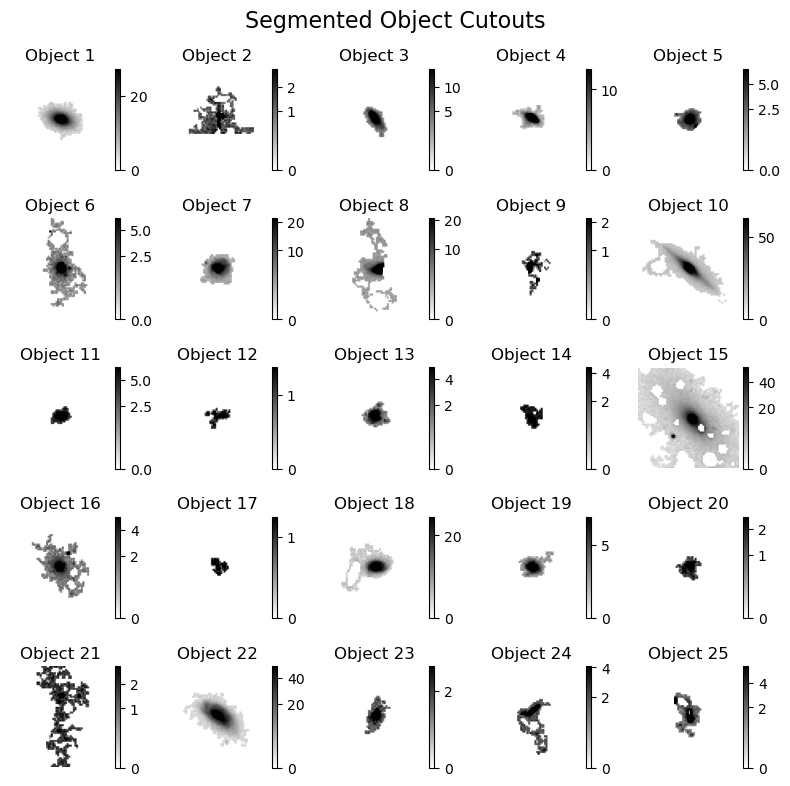

In [60]:
plot_cutouts(cutouts, num_cutouts=25)

In [1]:
from glob import glob
from vos import Client

def gather_cutout_data(parent_dir_source, parent_dir_destination, band='cfis_lsb-r'):
    pattern = os.path.join(parent_dir_source, "*_*", band, "*.r_cutouts.h5")
#     pattern = os.path.join(parent_dir_source, band, "*.r_cutouts.h5")
    cutout_files = Client().glob(pattern)
    print(len(cutout_files))
    
    for file in tqdm(cutout_files[:10]):
        try:
            filename = os.path.basename(file)
            name, ext = os.path.splitext(filename)
            tile_numbers = filename.split('.')[1:3]
            tile_id = f'{tile_numbers[0].zfill(3)}_{tile_numbers[1].zfill(3)}'
            dir_destination = os.path.join(parent_dir_destination, tile_id, band)
            os.makedirs(dir_destination, exist_ok=True)
            temp_path = os.path.join(dir_destination, name+'_temp'+ext)
            final_path = os.path.join(dir_destination, filename)
            
            print(f'Downloading {filename} for band {band}...')
            
            result = subprocess.run(
            f'vcp -v {file} {temp_path}', shell=True, stderr=subprocess.PIPE, text=True)

            result.check_returncode()

            os.rename(temp_path, final_path)
            
            print(f'Successfully downloaded {filename} for band {band} to {dir_destination}.')
            
        except Exception as e:
            print(f"Error downloading file {file}: {str(e)}")
            continue

In [ ]:
parent_dir_source = 'arc:/projects/unions/ssl/data/raw/tiles/dwarforge' 
parent_dir_destination = '/home/nick/astro/DwarForge/data'

gather_cutout_data(parent_dir_source, parent_dir_destination, band='cfis_lsb-r')